In [100]:
import pandas as pd
import numpy as np
import json
from tqdm import tqdm

In [13]:
splits = json.load(open('tests/data/mmimdb/split.json'))
splits.keys(), splits['train'][:10]

(dict_keys(['train', 'dev', 'test']),
 ['0106714',
  '0204504',
  '1865357',
  '0033804',
  '0066423',
  '0045130',
  '0114323',
  '0087983',
  '0185014',
  '1117523'])

In [17]:
for k, v in splits.items():
    print(f"{k}: {len(v)=}")

train: len(v)=15552
dev: len(v)=2608
test: len(v)=7799


In [45]:
use_keys = ['title', 'kind', 'rating', 'votes', 'genres', 'plot', 'plot outline']
data = []
for sample_id in tqdm(splits['train']):
    item = json.load(open(f'tests/data/mmimdb/dataset/{sample_id}.json'))
    item = {k: item[k] for k in use_keys if k in item}
    item.update({"split": "train", "id": sample_id})
    data.append(item)
for sample_id in tqdm(splits['dev']):
    item = json.load(open(f'tests/data/mmimdb/dataset/{sample_id}.json'))
    item = {k: item[k] for k in use_keys if k in item}
    item.update({"split": "dev", "id": sample_id})
    data.append(item)
for sample_id in tqdm(splits['test']):
    item = json.load(open(f'tests/data/mmimdb/dataset/{sample_id}.json'))
    item = {k: item[k] for k in use_keys if k in item}
    item.update({"split": "test", "id": sample_id})
    data.append(item)

100%|██████████| 7799/7799 [01:06<00:00, 116.79it/s]


In [47]:
df = pd.DataFrame(data)

In [49]:
df.isna().sum()

title           0
kind            0
rating          4
votes           4
genres          0
plot            0
plot outline    2
split           0
id              0
dtype: int64

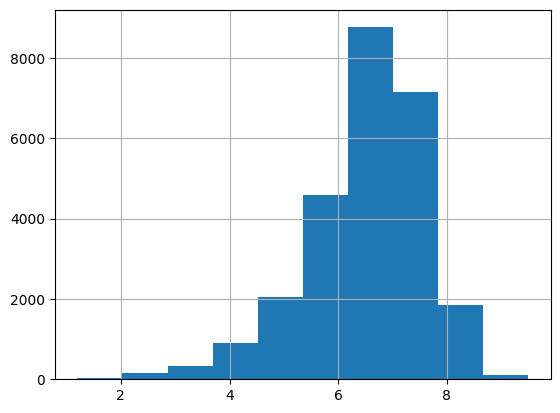

In [52]:
df.rating.hist();

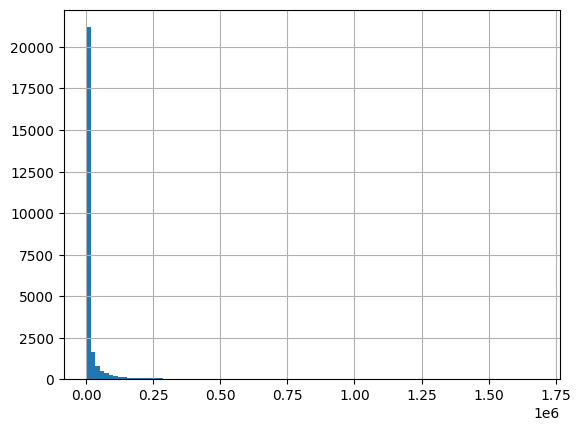

In [55]:
df.votes.hist(bins=100);

In [65]:
df.votes.quantile(0.9)

44427.20000000009

In [64]:
df[['title', 'votes', 'genres']].sort_values(by='votes', ascending=False)

,title,votes,genres
8707,The Shawshank Redemption,1680289.0,"[Crime, Drama]"
14755,The Dark Knight,1665309.0,"[Action, Adventure, Crime, Drama, Thriller]"
15514,Inception,1458826.0,"[Action, Adventure, Sci-Fi, Thriller]"
3791,Fight Club,1339192.0,[Drama]
11226,Pulp Fiction,1316986.0,"[Crime, Drama]"
...,...,...,...
24699,alaskaLand,5.0,[Drama]
10171,The Great Gatsby,NaN,[Drama]
12073,Sun Kissed,NaN,[Documentary]
20265,A Hand of Peace: Pope Pius XII and the Holocaust,NaN,[Documentary]


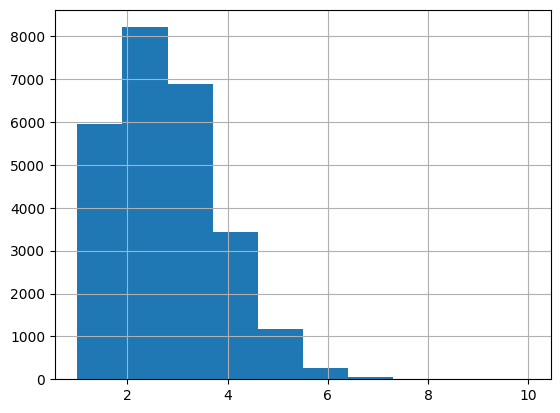

In [68]:
df[['title', 'votes', 'genres']].sort_values(by='votes', ascending=False)['genres'].apply(len).hist();

In [69]:
df['genre'] = df['genres'].apply(set)

In [86]:
use_genres = df.genre.value_counts().index[df.genre.value_counts() >= 4].tolist()

In [93]:
df = df[df.genre.isin(use_genres)].sort_values(by='votes', ascending=False).reset_index(drop=True)

In [99]:
np.median(df.genre.value_counts().values) 

9.0

In [111]:
df['genre'] = df['genre'].apply(lambda x: " - ".join(list(x)))

In [113]:
df = df.groupby('genre', as_index=False).head(np.median(df.genre.value_counts().values))

In [122]:
from sklearn.preprocessing import LabelEncoder

In [123]:
df = df[['id', 'title', 'plot outline', 'genre']]
label_encoder = LabelEncoder()
df['genre_id'] = label_encoder.fit_transform(df['genre'])

/tmp/ipykernel_29725/2718046439.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genre_id'] = label_encoder.fit_transform(df['genre'])


In [128]:
df = df.sample(frac=1, random_state=0).reset_index(drop=True)

In [130]:
total_samples = len(df)
train_samples = int(total_samples * 0.5)
dev_samples = int(total_samples * 0.25)
test_samples = total_samples - train_samples - dev_samples

In [131]:
splits = ['train'] * train_samples + ['dev'] * dev_samples + ['test'] * test_samples
np.random.shuffle(splits)
df['split'] = splits

In [133]:
df.split.value_counts()

split
train    2142
test     1072
dev      1071
Name: count, dtype: int64

In [138]:
df = df.rename(columns={"id": "image_path"})
df['image_path'] = df['image_path'] + '.jpeg'

In [139]:
df

,image_path,title,plot outline,genre,genre_id,split
0,0995739.jpeg,Naam yi boon sik,Three cops team up to bring down a criminal ga...,Crime - Action,164,train
1,0077598.jpeg,Gates of Heaven,A documentary about a pet cemetery in Californ...,Drama - Comedy - Documentary,265,train
2,0100029.jpeg,Lionheart,Lyon Gaultier is a deserter in the Foreign Leg...,Sport - Drama - Action,574,train
3,0081558.jpeg,Steel,Mike Catton was once a world-renowned construc...,Adventure - Crime - Drama - Action,40,train
4,0075807.jpeg,Candleshoe,Small-time crook Harry Bundage discovers that ...,Drama - Family - Comedy - Adventure,278,train
...,...,...,...,...,...,...
4280,1924396.jpeg,La migliore offerta,In the world of high-end art auctions and anti...,Crime - Drama - Mystery - Romance,201,train
4281,0336693.jpeg,Khaneh siah ast,"Set in a leper colony in the north of Iran, Th...",Short - Documentary,558,dev
4282,0419749.jpeg,Find Me Guilty,"Based on the true story of Jack DiNorscio, a m...",Biography - Crime - Drama - Comedy,82,train
4283,0044760.jpeg,Ivanhoe,A knight seeks to free the captive King Richar...,Romance - Drama - History - Adventure,525,dev


In [142]:
import os
import shutil

In [144]:
for path in df.image_path.tolist():
    shutil.copy(f'tests/data/mmimdb/dataset/{path}', f'tests/data/tinymmimdb/images/{path}')

In [145]:
df.to_csv('tests/data/tinymmimdb/data.csv', index=False)